# Chess Analytics: The Relationship Between Rating Discrepancy and Various National Metrics

## Data Analysis and Visualization Notebook (2/2)

This is the second of two notebooks that we will be using for our Milestone I project. Please refer to our project proposal for a more detailed description of our project:
https://docs.google.com/document/d/14McqLTo34VNHqz9b9nDVB8Mm_TcqahvEnPhvw_gUYmk/edit?usp=sharing

In [1]:
#!pip install json plotly haversine seaborn matplotlib statsmodels

### Imports
We import the plotting libraries, and from the clean_manipulate notebook, we import the five dataframe we'll be working with for the analysis and visualizations..

In [2]:
import json
import numpy as np
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
from haversine import haversine, Unit
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [3]:
from clean_manipulate import olympiads_merge_df as olympiad_df
from clean_manipulate import world_bank_df
from clean_manipulate import rated_players_df as player_df
from clean_manipulate import country_codes_table as key_table
from clean_manipulate import country_capital_df as capital_df
OLYMPIAD_YEARS = [2010, 2012, 2014, 2016, 2018, 2022];

The countries.geojson file has already been downloaded.
The country-capital-lat-long-population.csv file has already been downloaded.
The chessResultsList_2010.xlsx file has already been downloaded.
The chessResultsList_2012.xlsx file has already been downloaded.
The chessResultsList_2014.xlsx file has already been downloaded.
The chessResultsList_2016.xlsx file has already been downloaded.
The chessResultsList_2018.xlsx file has already been downloaded.
The chessResultsList_2022.xlsx file has already been downloaded.
The FIDE rating lists have already been downloaded.
ID number Name                              TitlFed  Jan12 GamesBorn  Flag

10207538  A E M, Doshtagir                      BAN  1864    0        i

10206612  A K M, Sourab                         BAN  1714    0        i

ID Number      Name                                                         Fed Sex Tit  WTit OTit           jan13 Gms K  B-day Flag

10207538       A E M, Doshtagir                                     

### 0. Preparing the GeoJSON Object for the Choropleth Maps

1. **Loading GeoJSON Data**: We start by loading a GeoJSON file located at the specified path. GeoJSON is a format for encoding geographic data structures.

2. **Data Transformation**: We iterate through the features in the GeoJSON data and perform some transformations on each feature. Specifically:
    - We assign an 'id' to each feature based on the 'ISO_A3' property from the original GeoJSON data. In this notebook, id is generally country code (ISO).
    - We check if the 'id' exists in the set of country codes provided by `key_table`. If it does, we include the feature in the `features` list.

3. **Creating a New GeoJSON Object**: Finally, we construct a new GeoJSON object called `countries_geojson`, which is a FeatureCollection containing the filtered features. This new GeoJSON object contains only the data relevant to our analysis or visualization.


In [4]:
path = 'data/secondary/country-capital-lat-long-population/countries.geojson'
map_countries = json.load(open(path,'r'))
features = []
for i,feature in enumerate(map_countries['features']):
    feature['id'] = map_countries['features'][i]['properties']['ISO_A3']
    if feature['id'] in set(key_table['country_code']):
        features.append(map_countries['features'][i])
countries_geojson = {'type': 'FeatureCollection'}
countries_geojson['features'] = features

### 1. Building the Chess Culture Index

Quantifying the chess culture of a country involves evaluating several key factors that collectively represent the nation's engagement and success in chess. These factors include:

1. **Chess Masters Density:** Offers insights into the popularity but may be influenced by population.

2. **Chess Masters Count:** Provides a quantitative measure of dedicated players.

3. **Total Years of Top Chess Players:** Reflects international dominance and consistency.

4. **Total Number of Top Chess Players:** Indicates the country's ability to produce strong players.

5. **Geographical Proximity to Chess Powerhouses:** Influence of neighboring countries with prominent chess figures can significantly impact a nation's own chess scene.

Collectively, these factors help assess the chess culture of a country, considering aspects such as player quantity and quality, international presence, and external influences. Our Chess Culture Index, assigns weights to these factors based on their perceived importance and then aggregate the scores to rank countries by their chess culture strength.

#### 1.1 Chess Masters Density:
Before calculating density, we first need to extract population from the world_bank_df into population_df

In [5]:
world_bank_df = world_bank_df[world_bank_df["Country Code"].isin(set(key_table['country_code']))]
population_df = world_bank_df[world_bank_df['Series Name'] == "Population, total"] \
    .drop(columns=['Series Name','Series Code','2007 [YR2007]','2021 [YR2021]','2022 [YR2022]'])
population_df.columns = ['country','country_code'] + [str(i) for i in range(2008, 2021)]
population_df[[str(i) for i in range(2008, 2021)]] = population_df[[str(i) for i in range(2008, 2021)]].astype(int)
population_df.head()

country country_code      2008      2009      2010      2011  \
5    Afghanistan          AFG  26427199  27385307  28189672  29249157   
29       Albania          ALB   2947314   2927519   2913021   2905195   
53       Algeria          DZA  34569592  35196037  35856344  36543541   
101      Andorra          AND     76055     73852     71519     70567   
125       Angola          AGO  21691522  22507674  23364185  24259111   

         2012      2013      2014      2015      2016      2017      2018  \
5    30466479  31541209  32716210  33753499  34636207  35643418  36686784   
29    2900401   2895092   2889104   2880703   2876101   2873457   2866376   
53   37260563  38000626  38760168  39543154  40339329  41136546  41927007   
101     71013     71367     71621     71746     72540     73837     75013   
125  25188292  26147002  27128337  28127721  29154746  30208628  31273533   

         2019      2020  
5    37769499  38972230  
29    2854191   2837849  
53   42705368  43451666  
101     76343     77700  
125  32353588  33428486

#### 1.1 Chess Masters Density & 1.2 Chess Masters Count:

The main steps are as follows:

1. **Filtering by Player Titles:** The code filters the original DataFrame `player_df` to retain only players with titles 'GM' (Grandmaster), 'IM' (International Master), or 'FM' (FIDE Master).

2. **Grouping and Aggregating Data:** The filtered data is grouped by `fide_id`, `federation`, and `title`, and the first entry in each group is selected. It then counts the titles within each 'federation'. This operation captures the number of unique FMs, IMs, and GMs from this country in the timeframe we're interested in.

3. **Reshaping Data:** The result is reshaped into a new DataFrame where `federation` becomes the index, and `level_1` (representing player titles) becomes columns. NaN values are filled with zeros, and the data is cast to integer type.

4. **Calculating Master Score:** The code calculates a `master_score` for each federation based on the counts of FM, IM, and GM titles, assigning different weights to each title.

5. **Merging Data:** Population data from the year 2015 is merged into the DataFrame based on `country_code`, and additional columns are selected to create the final DataFrame.

6. **Logarithmic Transformation and Metric Calculation:** A logarithmic transformation of `master_score` per capita is computed, and a `metric` is calculated as the product of `master_score` and the logarithmic value. The justification for using the logarithmic value is that between different countries, `master_score` varies by count, while `master_score_per_capita` varies by orders of magnitude (since country population varies by orders of magnitudes).

7. **Sorting and Output:** The DataFrame is sorted by the 'metric' column in descending order, and the top entries are displayed. `gm_per_capita_df` displays a Chess Culture Index by considering player titles, population data, and a weighted metric. It provides insights into the strength of chess culture in different federations, with higher metric values indicating stronger chess cultures.

In [6]:
def title_count(masters):
    return masters['title'].value_counts()

master_df = player_df[player_df['title'].isin(set(['GM','IM','FM']))]

gm_per_capita = master_df \
    .groupby(['fide_id', 'federation', 'title']).first().reset_index() \
    .groupby('federation').apply(title_count)

gm_per_capita_df = gm_per_capita.reset_index() \
    .pivot(index='federation', columns='level_1', values='title')
gm_per_capita_df = gm_per_capita_df.fillna(0).astype(int).reset_index()
gm_per_capita_df.columns = ['fed'] + list(gm_per_capita_df.columns[1:])

# Calculate Master Score
for fide_code in key_table['fide_code']:
    if fide_code not in set(gm_per_capita_df['fed']):
        gm_per_capita_df = pd.concat([
            gm_per_capita_df,
            pd.DataFrame({
                'fed': [fide_code],
                'FM': [0],
                'IM': [0],
                'GM': [0]
            })
        ], ignore_index=True)

df = gm_per_capita_df #improve readability
feds_drop = df[~df['fed'].isin(key_table['fide_code'])]
df = df.drop(feds_drop.index)
df['master_score'] = df['FM'] + 2 * df['IM'] + 25 * df['GM']
df = df.sort_values(by='master_score', ascending=False).reset_index(drop=True)

# Get Population and Per Capita Score
pop_2015_df = population_df[['country_code','2015']]
df = pd.merge(df, key_table, left_on='fed', right_on='fide_code', how='left')
df = pd.merge(df, pop_2015_df, left_on='country_code', right_on='country_code', how='left')

df = df[['country_code','fed','federation','FM','IM','GM','master_score','2015']]
df.columns = ['id','fed','federation','fm','im','gm','master_score','population']
df['per_capita_master_log'] = np.log10(df['master_score'] / df['population'] * 1e9 + 1)
df['metric'] = df['master_score'] * df['per_capita_master_log']
df = df.sort_values(by='metric', ascending=False).reset_index(drop=True)
gm_per_capita_df = df #update original df
gm_per_capita_df.head()

id  fed          federation    fm   im   gm  master_score  population  \
0  RUS  RUS  Russian Federation  1377  620  267          9292   144096870   
1  DEU  GER             Germany   983  315  104          4213    81686611   
2  UKR  UKR             Ukraine   233  239  103          3286    45154036   
3  USA  USA       United States   479  213  117          3830   320738994   
4  SRB  SRB              Serbia   392  141   63          2249     7095383   

   per_capita_master_log        metric  
0               4.809461  44689.515223  
1               4.712449  19853.547642  
2               4.861977  15976.456264  
3               4.077083  15615.229342  
4               5.501015  12371.782696

#### 1.3 Total Years of Top Chess Players & 1.4 Total Number of Top Chess Players:

The main steps are as follows:

1. **Filtering Top Players:** The code first filters the original DataFrame player_df to include only players with a rating greater than 2700, which typically represents top-level chess players. The resulting DataFrame is named top_players_df.

2. **Name Formatting:** It then formats the player names, splitting them into first and last names if they are provided in the 'name' column.

3. **Grouping and Aggregating Data:** `top_players_df` is grouped by `federation` and `name`, counting the number of appearances of each player within a federation. This operation helps identify how many times each top player has represented their federation.

4. **Calculating Unique Players:** We then calculate the count of unique top players for each federation by counting the unique names within each federation group.

5. **Data Merging:** The analysis incorporates additional data by merging with the `key_table` DataFrame based on the `federation` code and the `capital_df` DataFrame based on latitude and longitude coordinates.

6. **Selecting Relevant Columns:** The DataFrame is then structured to retain columns related to country codes, geographical coordinates, population, count of top players, unique top players, and federation names.

7. **Sorting and Output:** Finally, the resulting DataFrame, named `top_players_counts_df`, is sorted by the `top_years` column in descending order. This DataFrame provides insights into the presence and influence of top chess players within different federations, with a focus on the count of appearances and uniqueness of top players.

In [7]:
top_players_df = player_df[player_df['rating'] > 2700].reset_index(drop=True)
names = []
for i,row in top_players_df.iterrows():
    try:
        names.append(row['name'].split(',')[1]+' '+row['name'].split(',')[0])
    except:
        names.append(row['name'])
top_players_df['name'] = names
top_players_counts = top_players_df \
    .groupby(['federation', 'name']).size() \
    .reset_index(name='count').groupby('federation') \
    .agg({'name': list, 'count': 'sum'}).reset_index()
top_players_counts['unique_players'] = top_players_counts['name'].apply(lambda x:len(x))
top_players_counts = top_players_counts[top_players_counts['federation'] != 'FID']

df = pd.merge(top_players_counts, key_table, left_on='federation', right_on='fide_code', how='left')
df = pd.merge(df, capital_df, left_on='federation_lat_long', right_on='Country', how='left')
df = df[['country_code','Latitude','Longitude','Population','count','unique_players','federation_y']]
df.columns = ['id', 'latitude', 'longitude', 'population', 'top_years', 'top_players', 'country']
df = df.sort_values(by='top_years', ascending=False).reset_index(drop=True)
top_players_counts_df = df
top_players_counts_df.head()

id  latitude  longitude  population  top_years  top_players  \
0  RUS   55.7550    37.6218    12409738        159           23   
1  CHN   39.9075   116.3972    19617963         57            7   
2  USA   38.8951   -77.0364     5206593         49           11   
3  UKR   50.4454    30.5186     2956706         37            9   
4  AZE   40.3777    49.8920     2285729         37            5   

                       country  
0           Russian Federation  
1  China, People's Republic of  
2                United States  
3                      Ukraine  
4                   Azerbaijan

#### 1.5 Geographical Proximity to Chess Powerhouses

Finally, we compute a measure of chess culture proximity for a given country to known chess hubs (federations with strong chess cultures) based on their geographical proximity, and then it computes a chess culture index. The main steps are as follows:

1. **`country_dis_to_chess_hubs` Function:** This function calculates the cultural weight for a given country based on its geographical distance to known chess hubs. It takes the following parameters:
   - `country`: The name of the country for which cultural weights are calculated.
   - `hubs_data` (optional): A DataFrame containing information about chess hubs, including their geographical coordinates.
   - `hub_reach` (optional): A reach parameter representing how far the chess culture of a hub can spread.

2. **`generate_distance_matrix` Function:** This function generates a distance matrix that represents the cultural proximity of countries to chess hubs. It takes the following parameters:
   - `culture_ordering`: The ordering of cultures (federations) based on the Chess Culture Index.
   - `matrix_ordering`: The ordering of federations in the resulting distance matrix.

3. **Calculating Cultural Proximity:** The code calculates the cultural proximity matrix by iterating through each federation in `matrix_ordering` and computing cultural weights using the `country_dis_to_chess_hubs` function.

4. **Combining Cultural Proximity:** The cultural proximity matrix is combined with the weight matrix, which reflects the chess culture strength of each federation.

5. **Logarithmic Transformation:** The logarithmic transformation is applied to the combined matrix.

6. **Standardization:** The culture values are standardized to have zero mean and unit variance.

7. **Creating the Culture Table:** The final culture table is created, containing columns for federation codes, names, and the standardized chess culture index.

In [8]:
default_data = top_players_counts_df[['id', 'latitude', 'longitude']]
default_reach = top_players_counts_df['top_years']*30

def country_dis_to_chess_hubs(country, hubs_data=default_data, hub_reach=default_reach):
    coords = capital_df[capital_df['Country'] == country][['Latitude','Longitude']].iloc[0]
    country_coordinates = tuple([coords['Latitude'],coords['Longitude']])
    distances = []
    for _,hub in hubs_data.iterrows():
        hub_coordinates = tuple([hub['latitude'], hub['longitude']])
        distance = haversine(country_coordinates, hub_coordinates, unit=Unit.KILOMETERS)
        distances.append(distance)
    dist_vec = np.array(distances, dtype=float)
    mask = dist_vec < hub_reach
    culture_weight = np.array([(1-dist/hub)**2 if dist<hub else 0 for dist, hub in zip(dist_vec, hub_reach)])
    #culture spread is inversely proportional to distance
    return culture_weight

def generate_distance_matrix(cul_ord=top_players_counts_df['id'], mat_ord=gm_per_capita_df.copy()['id']):
    top_indices = []
    country_vecs = []
    for code in cul_ord:
        index = gm_per_capita_df[gm_per_capita_df.copy()['id'] == code].index[0]
        top_indices.append(index)
    for fed in mat_ord:
        country = key_table[key_table.copy()['country_code'] == fed]['federation_lat_long'].iloc[0]
        index = gm_per_capita_df[gm_per_capita_df.copy()['id'] == fed].index[0]
        vector = np.zeros(len(mat_ord))
        weights = country_dis_to_chess_hubs(country)
        vector[top_indices] = weights
        if fed in set(cul_ord):
            reign = top_players_counts_df[top_players_counts_df['id']==fed]['top_years'].iloc[0]
            kings = top_players_counts_df[top_players_counts_df['id']==fed]['top_players'].iloc[0]
            vector[index] = vector[index] + 1 + reign/10 + kings/2
        else:
            vector[index] = vector[index] + 1
        country_vecs.append(vector)
    matrix = np.vstack(country_vecs)
    return matrix

In [9]:
distance_matrix = generate_distance_matrix()
weights_matrix = np.array(gm_per_capita_df['metric']).reshape(-1,1)
cultures = np.dot(distance_matrix, weights_matrix)
cultures = np.log10(cultures + 1)
cultures_standard = (cultures - np.mean(cultures)) / np.std(cultures)

In [10]:
culture_table = gm_per_capita_df.copy()[['id','fed','federation']]
culture_table['chess_culture'] = cultures_standard
culture_table = culture_table.sort_values(by='chess_culture', ascending=False).reset_index(drop=True)
culture_table.columns = ['id','fide_code','federation','chess_culture']
culture_table.head()

id fide_code          federation  chess_culture
0  RUS       RUS  Russian Federation       2.093800
1  UKR       UKR             Ukraine       1.607546
2  USA       USA       United States       1.606275
3  HUN       HUN             Hungary       1.425142
4  DEU       GER             Germany       1.366778

### 2. Choropleth Visualization for Chess Culture

1. **Choropleth Map Creation:** It uses Plotly Express (`px.choropleth_mapbox`) to create a choropleth map. The map color-codes countries based on their Chess Culture Index, with hover information displaying federation names.

2. **Influence Reach for Chess Hubs:** The code iterates through `top_players_counts_df` to create custom markers on the map. Each marker represents a chess hub and includes information like country, the number of Grandmasters (GMs), and the number of top players.

3. **Influence Size and Text:** Influence size is determined by the Chess Culture Index, and influence text provides information about the country.

4. **Map Layout Settings:** The map's layout and appearance are configured, including its initial center, zoom level, and size.

5. **Overlaying Custom Markers:** Custom Influence markers are added to the culture map to show the geographical locations of the capital of chess hub countries.

6. **Display the Map:** The final culture map, showing Chess Culture Index and influence of countries with great chess influence, is displayed.

In [11]:
# Create a choropleth map using Plotly Express to visualize the Chess Culture Index
culture_map = px.choropleth_mapbox(
    culture_table, 
    locations='id',  # Use 'id' column as location identifier
    geojson=countries_geojson,  # GeoJSON data for country boundaries
    color='chess_culture',  # Color the map based on the chess culture index
    hover_name='federation',  # Show federation names on hover
    mapbox_style='carto-positron',  # Use Carto Positron map style
    center={'lat': 0, 'lon': 0},  # Set the initial map center
    zoom=0.5,  # Set the initial zoom level
    color_continuous_scale=px.colors.diverging.RdYlGn  # Choose a color scale
)

# Create custom markers for top chess players
marker_coords = []
marker_texts = []
sizes = []
names = []

# Iterate through top players' data to create custom markers
for i, row in top_players_counts_df.iterrows():
    id = row['id']
    lat = row['latitude']
    lon = row['longitude']
    marker_coords.append({'lat': lat, 'lon': lon})
    
    # Retrieve relevant information for the marker text
    rank = culture_table[culture_table['id'] == id].index[0] + 1
    country = top_players_counts_df[top_players_counts_df['id'] == id]['country'].iloc[0]
    gms = gm_per_capita_df[gm_per_capita_df['id'] == id]['gm'].iloc[0]
    tops = top_players_counts_df[top_players_counts_df['id'] == id]['top_players'].iloc[0]

    # Calculate marker size based on the chess culture index
    size = culture_table[culture_table['id'] == id]['chess_culture'].iloc[0]
    size = size**3 * 10
    
    # Create marker text
    text = '{}, \nGrandmasters: {} \nTop Players: {}'.format(country, gms, tops)
    name = 'Rank: {} \n {}'.format(rank, id)
    
    marker_texts.append(text)
    sizes.append(size)
    names.append(name)

custom_marker_traces = []

# Create custom marker traces for top chess players
for i in range(len(marker_coords)):
    custom_marker_trace = go.Scattermapbox(
        lat=[marker_coords[i]['lat']],
        lon=[marker_coords[i]['lon']],
        mode='markers',
        marker=dict(
            symbol='circle',
            size=sizes[i],
            color='#ffbb00',  # Custom marker color
            opacity=0.5,
        ),
        textposition='bottom center',
        text=marker_texts[i],
        showlegend=False,
        name=names[i]
    )
    custom_marker_traces.append(custom_marker_trace)

# Update map layout and settings
culture_map.update_geos(fitbounds="locations", visible=False)
culture_map.update_layout(
    height=750,
    width=1000,
)

# Add custom markers to the culture map
for trace in custom_marker_traces:
    culture_map.add_trace(trace)

# Show the culture map
culture_map.show()
#print('Uncomment to show choropleth map')

Uncomment to show choropleth map


### 3. Choropleth Visualization for Rating Discrepancy
#### 3.1 Function `get_country_performance` summary:

it calculates the performance of a given country's chess players in various years based on data from an Olympiad dataset. The function accepts the following parameters:

- `country_fide_id`: The FIDE code or identifier of the country for which performance is calculated.
- `no_top_players` (optional, default=True): A boolean flag that determines whether top-rated players (with a rating of 2700 or higher) should be included in the performance calculations.

Here's a breakdown of the function's key steps:

1. **Filtering Olympiad Data:** The function filters the Olympiad dataset (`olympiad_df`) to select data entries corresponding to the specified country using the `country_fide_id`.

2. **Yearly Performance Calculation:** For each unique year in the filtered data, the function calculates the average performance of the country's chess players. The performance is computed by subtracting the player's actual rating from their rating performance. This step is performed separately for each year's Olympiad.

3. **Excluding Top Players (Optional):** If the `no_top_players` flag is set to `True`, the function further filters the player data to exclude top-rated players (those with a rating of 2700 or higher) from the performance calculations. This is achieved by checking each player's rating before calculating their performance.

4. **Average Performance Calculation:** For each year, the function calculates the weighted average performance of the country's players. The performance of each player is weighted by the number of games they played in that year's Olympiad. The weighted average is then computed for all players in that year's Olympiad.

5. **Data Storage:** The function stores the average performances for each year in a list of dictionaries, where each dictionary maps a year to its corresponding average performance.

6. **Return:** The function returns a list of dictionaries, where each dictionary contains the year as the key and the corresponding average performance as the value.


In [12]:
def get_country_performance(country_fide_id, no_top_players = True):
    olympiad_country_df = olympiad_df[olympiad_df['federation'] == country_fide_id]
    year_performance = []
    for year in olympiad_country_df['year'].unique():
        total_games = olympiad_country_df['games'].sum()
        performances = []
        for _,player in olympiad_country_df[olympiad_country_df['year']==year].iterrows():
            if no_top_players:
                if player['rating'] < 2700:
                    if player['rating'] != 0:
                        performance = player['rating_performance'] - player['rating']
                        performances.append([performance,player['games']])
            else:
                if player['rating'] != 0:
                    performance = player['rating_performance'] - player['rating']
                    performances.append([performance,player['games']])
        average_performance = 0
        for entry in performances:
            average_performance += entry[0]*entry[1]
        average_performance = average_performance/total_games
        year_performance.append({year:average_performance})
    return year_performance

#### 3.2 Building the Rating Discrepancy by Country Table

Next, we create a table that summarizes the rating discrepancy of chess players from different countries in various Olympiad years.

1. **Initialize DataFrame:** An empty DataFrame called `country_performance_olympiads_df` is created. This DataFrame will store rating discrepancy data for each country across different Olympiad years. The columns of this DataFrame represent the years of Olympiad events (stored in `OLYMPIAD_YEARS`).

2. **Loop Over Countries:** The code iterates over each country in `key_table` (a DataFrame containing `federations` and its matching foreign keys).

3. **Calculate Yearly Performances:** For each country, the `get_country_performance` function is called to calculate the performance of its chess players in each Olympiad year. The `True` argument passed to the function indicates that top-rated players (those with a rating of 2700 or higher) should be excluded from the calculations.

4. **Fill the DataFrame:** The calculated performance values are stored in the `country_performance_olympiads_df` DataFrame. Each row corresponds to a country, and each column represents the performance for a specific year.

5. **Calculate Average Performance:** A new column called 'average' is added to the DataFrame, which calculates the average performance for each country over all Olympiad years.

6. **Add Country Codes and Names:** Two additional columns are added to the DataFrame, 'fide_code' (country code) and 'id' (country name), by mapping the values from the `key_table` DataFrame.

7. **Standardize Average Performances:** The average performances are standardized to have zero mean and unit variance. This helps to highlight countries with performances significantly different from the mean while avoiding extreme outliers. This computation is only done for the choropleth visualization and will not be relevant in future analysis.

In [13]:
#build rating discrepancy by country table
country_performance_olympiads_df = pd.DataFrame(np.nan, index=range(len(key_table)), columns=OLYMPIAD_YEARS)
for i,fide_code in enumerate(key_table['fide_code']):
    year_performances = get_country_performance(fide_code, False)
    for perf in year_performances:
        country_performance_olympiads_df.loc[i,perf.keys()] = perf.values()
country_performance_olympiads_df.fillna(np.nan, inplace=True)
country_performance_olympiads_df['average'] = country_performance_olympiads_df.sum(axis=1, skipna=True)/len(OLYMPIAD_YEARS)
country_performance_olympiads_df['fide_code'] = key_table['fide_code']

mapping_dict_code = key_table.set_index('fide_code')['country_code'].to_dict()
mapping_dict_name = key_table.set_index('fide_code')['federation'].to_dict()
country_performance_olympiads_df['id'] = country_performance_olympiads_df['fide_code'].map(mapping_dict_code)
country_performance_olympiads_df['country_name'] = country_performance_olympiads_df['fide_code'].map(mapping_dict_name)

#correcting small sample countries
averages = np.array(country_performance_olympiads_df['average'])
country_performance_olympiads_df['average_standard'] = (averages - np.mean(averages)) / np.std(averages)
country_performance_olympiads_df['average_standard'] = np.clip(country_performance_olympiads_df['average_standard'], -2.5, 2.5) 
country_performance_olympiads_df = country_performance_olympiads_df.sort_values(by='average_standard', ascending=False)
country_performance_olympiads_df.head()

2010       2012       2014       2016       2018        2022  \
176       NaN        NaN        NaN        NaN        NaN  123.909091   
177       NaN        NaN        NaN        NaN        NaN  141.613636   
94  -4.103846  10.342308  24.692308  21.323077  11.142308   36.857692   
181       NaN        NaN        NaN        NaN        NaN   91.500000   
144       NaN  27.561321  16.174528  12.504717  26.877358  -16.117925   

       average fide_code   id    country_name  average_standard  
176  20.651515       CAY  CYM  Cayman Islands          2.500000  
177  23.602273       DMA  DMA        Dominica          2.500000  
94   16.708974       SRI  LKA       Sri Lanka          2.326705  
181  15.250000       LAO  LAO            Laos          2.175731  
144  11.166667       MDV  MDV        Maldives          1.753191

#### 3.3 Rating Discrepancy Map Visualization

*Creating the Choropleth Map:* The code uses Plotly Express (`px.choropleth_mapbox`) to create a choropleth map. It takes the following parameters:
   - `country_performance_olympiads_df`: The DataFrame containing country performance data.
   - `locations`: Specifies the column in the DataFrame to use as location identifiers. In this case, it uses the 'id' column, which represents country codes.
   - `geojson`: The GeoJSON data for country boundaries, provided by the `countries_geojson` variable.
   - `color`: The column in the DataFrame to use for coloring the map, which is 'average_standard' representing standardized average performances.
   - `hover_name`: The column to use for displaying country names on hover, which is 'country_name'.
   - `mapbox_style`: The style of the Mapbox map, set to 'carto-positron'.
   - `center`: The initial center of the map, specified as {'lat': 0, 'lon': 0}.
   - `zoom`: The initial zoom level of the map, set to 0.5.
   - `color_continuous_scale`: The color scale for the choropleth, using the 'RdYlGn' diverging color palette.

This choropleth map visualizes the standardized average performances of chess players from different countries. Countries with higher absolute `rating_discrepancy` are displayed with distinct colors, allowing for a quick assessment of their relative performance in chess.

In [14]:
olympiad_map = px.choropleth_mapbox(
    country_performance_olympiads_df, 
    locations = 'id',
    geojson = countries_geojson,
    color = 'average_standard',
    hover_name = 'country_name',
    mapbox_style = 'carto-positron',
    center = {'lat':0,'lon':0},
    zoom = 0.5,
    color_continuous_scale = px.colors.diverging.RdYlGn
)
olympiad_map.update_geos(fitbounds="locations", visible=False)
olympiad_map.update_layout(
    height=750,
    width=1000,
)
olympiad_map.show()
#print('Uncomment to show choropleth map')

Uncomment to show choropleth map


### 4. Choropleth Visualization for Economic Indicators

#### 4.1 Data Processing and Visualization Preparation

1. **Filter Data by GDP per Capita:** It begins by filtering the DataFrame `world_bank_df` to only include rows where the `Series Name` column is equal to `GDP per capita (current US$)`.

2. **Drop Irrelevant and Rename Columns:** We only keep data from the years2008 to 2020. The first two columns are renamed to 'country' and 'country_code', and the remaining columns are set to a range of years from 2008 to 2020.

3. **Identify Dropped Countries:** A list of 'country_code' values is created for rows that contain at least one NaN (Not-a-Number) value.

4. **Drop Rows with NaN Values:** Rows with NaN values are removed from the DataFrame (`gdp_per_capita_df`), effectively cleaning the data.

5. **Select Relevant Columns:** A subset of columns (`country`, `country_code`, and years `2010`, `2012`, `2014`, `2016`, `2018`, and `2022`) is selected from the DataFrame and assigned to a new DataFrame called `relevant_gdp_per_capita_df`. Before doing so, column names for years are adjusted (add 2 years). We will be using economic data from two years ago for any given year's Olympiad data.

6. **Preparing Data for Visualization:** A new DataFrame (`gdp_vis_df`) is created as a copy of `relevant_gdp_per_capita_df`. For each year in `OLYMPIAD_YEARS`, logarithmic normalization is applied to the corresponding columns, and these normalized columns are added to `gdp_vis_df`. Finally, the DataFrame is sorted by the most recent year's normalized values (2022 in this case).

In [15]:
# Extract GDP per capita data and drop irrelevant columns
gdp_per_capita_df = world_bank_df[world_bank_df['Series Name'] == "GDP per capita (current US$)"] \
    .drop(columns=['Series Name', 'Series Code', '2007 [YR2007]', '2021 [YR2021]', '2022 [YR2022]'])

# Rename columns
gdp_per_capita_df.columns = ['country', 'country_code'] + [i for i in range(2008, 2021)]

# Find and drop rows with missing values, then get the list of dropped country codes
gpd_dropped_countries = list(gdp_per_capita_df.loc[gdp_per_capita_df[gdp_per_capita_df.isna().any(axis=1)].index, 'country_code'])
gdp_per_capita_df = gdp_per_capita_df.dropna()

# Select relevant columns and rename them
relevant_gdp_per_capita_df = gdp_per_capita_df[['country', 'country_code', 2008, 2010, 2012, 2014, 2016, 2020]]
relevant_gdp_per_capita_df.columns = ['country', 'id', 2010, 2012, 2014, 2016, 2018, 2022]
relevant_gdp_per_capita_df.head()

# Prepare visualization data
gdp_vis_df = relevant_gdp_per_capita_df.copy()

# Normalize data for each year and add '_norm' suffix to column names
for year in OLYMPIAD_YEARS:
    yearly_data = np.array(relevant_gdp_per_capita_df[year]).astype(np.float64)
    gdp_vis_df.loc[:, '{}_norm'.format(year)] = np.log10(yearly_data)

# Sort by the normalized column for the specific year in descending order
gdp_vis_df = gdp_vis_df.sort_values(by='{}_norm'.format(year), ascending=False).reset_index(drop=True)
gdp_vis_df.head()

country   id              2010              2012              2014  \
0         Monaco  MCO  204097.210001824  161780.747483272  165497.072205962   
1  Liechtenstein  LIE  143540.573432591  141466.875379198   149461.70894907   
2     Luxembourg  LUX  120422.137934157  110885.991378724  112584.676270958   
3        Bermuda  BMU  106935.486341979   101875.28407346  98431.8651810241   
4    Switzerland  CHE  74175.8776377701  76531.3729407691  85836.2076767359   

               2016              2018              2022  2010_norm  2012_norm  \
0  195772.673042609  174606.493834998  182537.304600697   5.309837   5.208927   
1  179467.506904176  165845.928847599  165284.497122453   5.156975   5.150655   
2  123678.702143273  106899.293549555   117370.49690016   5.080706   5.044877   
3   98467.683993982  106885.878489327  107791.886435134   5.029122   5.008069   
4  88724.9909402638  82153.0745447889   85656.322666307   4.870263   4.883840   

   2014_norm  2016_norm  2018_norm  2022_norm  
0   5.218790   5.291752   5.242060   5.261352  
1   5.174530   5.253986   5.219705   5.218232  
2   5.051479   5.092295   5.028975   5.069559  
3   4.993136   4.993294   5.028920   5.032586  
4   4.933671   4.948046   4.914624   4.932759

#### 4.2 Economic Indicator (GDP per capita) Map Visualization

- `i = 5`: Selecting the index for the Olympiad year to visualize (e.g., 5 corresponds to the year 2022).

- `years = OLYMPIAD_YEARS`: Retrieving a list of Olympiad years from the variable `OLYMPIAD_YEARS`.

- `gdp_map = px.choropleth_mapbox(...)`: Creating a choropleth map using Plotly Express. The map will display the following information:
  - `gdp_vis_df`: Data containing GDP per capita information.
  - `locations='id'`: Using the 'id' column as the location identifier for countries.
  - `geojson=countries_geojson`: GeoJSON data defining the shapes of countries.
  - `color='{}_norm'.format(years[i])`: Coloring the map based on the normalized GDP per capita for the selected Olympiad year.
  - `hover_name='country'`: Displaying the country names when hovering over map regions.
  - `mapbox_style='carto-positron'`: Using the 'carto-positron' map style.
  - `center={'lat': 0, 'lon': 0}`: Centering the map at latitude 0 and longitude 0.
  - `zoom=0.5`: Setting the initial zoom level for the map.
  - `color_continuous_scale=px.colors.diverging.RdYlGn`: Defining the color scale for the map.


In [16]:
i=5
years = OLYMPIAD_YEARS
gdp_map = px.choropleth_mapbox(
    gdp_vis_df, 
    locations='id',
    geojson=countries_geojson,
    color='{}_norm'.format(years[i]),
    hover_name='country',
    mapbox_style='carto-positron',
    center={'lat': 0, 'lon': 0},
    zoom=0.5,
    color_continuous_scale=px.colors.diverging.RdYlGn
)

gdp_map.update_geos(fitbounds="locations", visible=False)
gdp_map.update_layout(height=750, width=1000)
gdp_map.show()
#print('Uncomment to show choropleth map')

Uncomment to show choropleth map


### 5. Scatterplot for Rating Discrepancy vs Economic Indicators

#### 5.1 Calculating Per-Olympiad Average Ratings

1. **Grouping Data:** The code starts by grouping the data in the `olympiad_df` DataFrame by two columns, 'federation' (representing the federation or country) and 'year' (representing the Olympiad year).

2. **Aggregating Data:** Within each group, the code performs two aggregations:
   - `total_games`: It calculates the sum of the 'games' column, which represents the total number of games played by players in that federation in that year.
   - `average_ratings`: It uses a custom aggregation function to calculate the weighted average of player ratings. It multiplies each player's rating by the number of games they played and then sums up these weighted ratings.

3. **Calculating Average Ratings:** After aggregating the data, the code divides the 'average_ratings' by the 'total_games' to compute the average rating for each federation in each Olympiad year. This step ensures that the average rating is a weighted average, taking into account the number of games played.

4. **Thresholding Ratings:** The code creates a new column called 'gt1000' that checks if the 'average_ratings' are greater than 1000 for each federation and year combination. This column can be used to filter or categorize federations based on whether their average ratings exceed the threshold of 1000.

We are not going to plot the federations whose average rating falls below 1000. Most of the time, an average team rating below 1000 means the federation may have just recently joined FIDE, and very few players are rated in that country. The 'gt1000' column will be used to identify federations with average ratings above this threshold.

In [17]:
per_olympiad_avg_rating = olympiad_df.groupby(['federation', 'year']).agg(
    total_games=('games', 'sum'),
    average_ratings=('games', lambda x: (x * olympiad_df['rating']).sum())
).reset_index()
per_olympiad_avg_rating['average_ratings'] = per_olympiad_avg_rating['average_ratings']/per_olympiad_avg_rating['total_games']
per_olympiad_avg_rating['gt1000'] = per_olympiad_avg_rating['average_ratings'] > 1000
per_olympiad_avg_rating.head()

federation  year  total_games  average_ratings  gt1000
0        AFG  2012           36         0.000000   False
1        AFG  2014           44      1995.750000    True
2        AFG  2016           44      1850.022727    True
3        AFG  2018           44      1949.886364    True
4        AFG  2022           44      1819.113636    True

#### 5.2 Creating a Subplot of Scatter Plots

The function `make_scatter_six_olympiad` creates a subplot of six scatter plots for visualizing data related to chess culture, average ratings, and performance in different Olympiad years.

1. **Subplot Initialization:** The function initializes a subplot with two rows and three columns using `make_subplots`. Each subplot corresponds to a different Olympiad year.

2. **Color Scale:** It defines a color scale using the 'RdYlGn' diverging color palette from Plotly Express (`px.colors.diverging.RdYlGn`).

3. **Loop Over Years:** The code iterates over each of the six Olympiad years in the `OLYMPIAD_YEARS` list.

4. **Data Collection:** For each year, it collects data points for the x-axis, y-axis, color scale, and labels (country names) from the `merged_df` DataFrame, which likely contains various data related to chess culture, performance, and ratings.

5. **Scatter Plot Trace:** It creates a scatter plot trace for the current year using the collected data. The trace is configured with the following properties:
   - `x_data` and `y_data` represent the x and y-axis data points.
   - `mode` is set to 'markers' to create a scatter plot.
   - `marker` properties are defined to specify the color and color scale based on the 'chess_culture' data.
   - `text` represents the labels (country names) to display on hover.
   - `name` is left empty, since text should suffice.

6. **Adding Trace to Subplot:** The created scatter plot trace is added to the subplot at the appropriate row and column based on the current year.

7. **Updating Y-Axis Range:** The y-axis range is updated for each subplot to ensure consistent scaling.

In [18]:
def make_scatter_six_olympiad(merged_df, x_cols=['{}_norm'.format(year) for year in OLYMPIAD_YEARS], y_cols=['{}'.format(year) for year in OLYMPIAD_YEARS]):
    fig = make_subplots(rows=2, cols=3, subplot_titles=OLYMPIAD_YEARS)
    color_scale = px.colors.diverging.RdYlGn
    for i in range(2):
        for j in range(3):
            year_ind = 3 * i + j
            year = OLYMPIAD_YEARS[year_ind]
            x_data = []
            y_data = []
            color_data = []
            country_labels = []
    
            for code in merged_df['fide_code']:
                try:
                    if per_olympiad_avg_rating[(per_olympiad_avg_rating['federation'] == code) & (per_olympiad_avg_rating['year'] == year)]['gt1000'].iloc[0]:
                        x_data.append(merged_df.loc[merged_df['fide_code'] == code, x_cols[year_ind]].iloc[0])
                        y_data.append(merged_df.loc[merged_df['fide_code'] == code, y_cols[year_ind]].iloc[0])
                        color_data.append(merged_df.loc[merged_df['fide_code'] == code, 'chess_culture'].iloc[0])
                        country_labels.append(merged_df.loc[merged_df['fide_code'] == code, 'country_name'].iloc[0])
                    else:
                        continue
                except:
                    continue
            
            trace = go.Scatter(
                x=x_data,
                y=y_data,
                mode='markers',
                marker=dict(
                    color=color_data,
                    colorscale=color_scale,
                    cmin=-1.5,
                    cmax=2,
                    colorbar=dict(title='Chess Culture'),
                ),
                text=country_labels,
                name='',
            )
            fig.add_trace(trace, row=i + 1, col=j + 1)
            fig.update_yaxes(range=[-100,64], row=i + 1, col=j + 1)
    fig.update_layout(height=900, width=1200)
    return fig

#### 5.3 Scatterplot Preparation and Visualization

**A. Data Manipulation and Preparation:**

1. **Column Selection:** The code selects specific columns from the `gdp_vis_df` DataFrame (columns 0, 1, and columns 8 to 13). These columns contain the relevant data for our visualization, such as country name, country code, and normalized GDP.

2. **Data Merging:** It merges the selected columns from the `gdp_vis_df_norm` DataFrame with the `culture_table` DataFrame based on the 'id' column and with the `country_performance_olympiads_df` DataFrame based on the 'id' and 'fide_code' columns. This step combines GDP, chess culture, and Olympiad performance data into a single DataFrame called `olympiad_gdp_culture_df`.

3. **Column Renaming:** The code renames the columns of the merged DataFrame to ensure all column names are of string data type.

4. **Data Type Conversion:** It converts specific numeric columns in the DataFrame to float data type, so that rating discrepancy, normalized GDP, and chess culture will properly render.

**B. Scatter Plot Visualization:**

1. **Scatter Plot Creation:** The `make_scatter_six_olympiad` function is called to create a scatter plot matrix `olympiad_gdp_culture_vis`. This matrix contains six scatter plots, each corresponding to a different Olympiad year.

2. **Layout Configuration:** The layout of the scatter plot matrix is configured, including the title, axis labels, and axis titles for specific subplots.

3. **Displaying the Plot:** Finally, the scatter plot matrix is displayed using the `show` method.

We put all the necessary information into one `merged_df` and pass it into the function `make_scatter_six_olympiad`, which renders a visual representation of how these factors are related and can be useful for exploring potential correlations or patterns in the data.

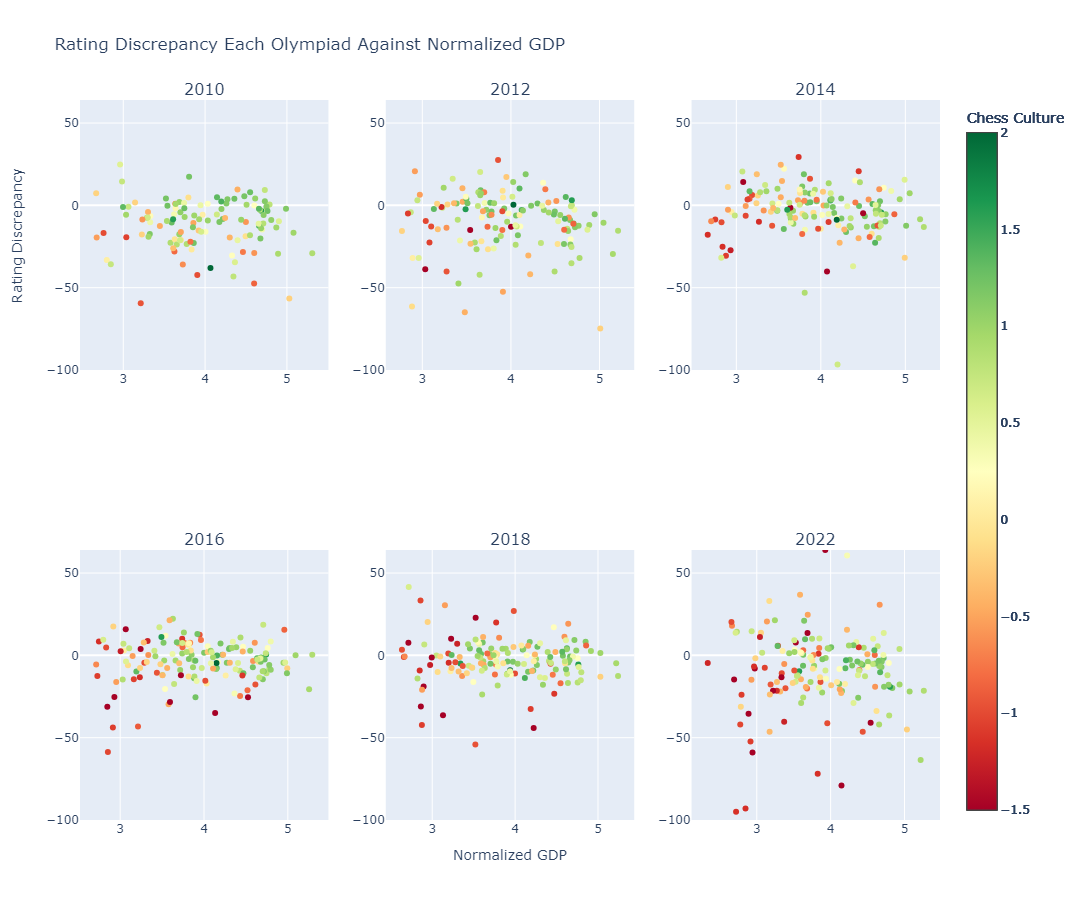

In [19]:
gdp_vis_df_norm = gdp_vis_df.iloc[:,[0,1,8,9,10,11,12,13]]
olympiad_gdp_culture_df = pd.merge(gdp_vis_df_norm, culture_table, on='id')
olympiad_gdp_culture_df = pd.merge(olympiad_gdp_culture_df, country_performance_olympiads_df, on=['id','fide_code'])
olympiad_gdp_culture_df.columns = [str(colname) for colname in olympiad_gdp_culture_df.columns]
numeric_cols = olympiad_gdp_culture_df.columns[[2,3,4,5,6,7,10,11,12,13,14,15,16,17,19]]
olympiad_gdp_culture_df[numeric_cols] = olympiad_gdp_culture_df[numeric_cols].astype(float)

olympiad_gdp_culture_vis = make_scatter_six_olympiad(olympiad_gdp_culture_df)

olympiad_gdp_culture_vis.update_layout(title_text='Rating Discrepancy Each Olympiad Against Normalized GDP', showlegend=False)
olympiad_gdp_culture_vis.update_xaxes(title_text='Normalized GDP', row=2, col=2)
olympiad_gdp_culture_vis.update_yaxes(title_text='Rating Discrepancy', row=1, col=1)
olympiad_gdp_culture_vis.show()

### 6. Scatterplot for Rating Discrepancy vs Average Team Rating

1. **Pivoting Data:** The code starts by pivoting the `per_olympiad_avg_rating` DataFrame. It rearranges the data so that each federation has columns representing average ratings for each Olympiad year. The new DataFrame, `pivot_poar_df`, is indexed by 'federation' and has columns for each year, denoted as 'year_average_ratings.'

2. **Column Renaming:** The columns in `pivot_poar_df` are renamed to include the year in their names.

3. **Data Merging:** The code merges the pivoted DataFrame with two other DataFrames:
   - `culture_table`: This DataFrame likely contains information about chess culture in different countries.
   - `country_performance_olympiads_df`: This DataFrame contains information about Olympiad performance, including rating discrepancies, for different countries.

4. **Scatter Plot Matrix Creation:** The `make_scatter_six_olympiad` function is used to create a scatter plot matrix (`olympiad_avgrating_culture_vis`) using Plotly. This matrix consists of six scatter plots, each corresponding to a different Olympiad year.

We further explored the relationship between rating discrepancies and average team ratings for multiple Olympiad years. The scatter plot matrix provides a visual representation of how these factors are related and can help identify any patterns or correlations in the data.

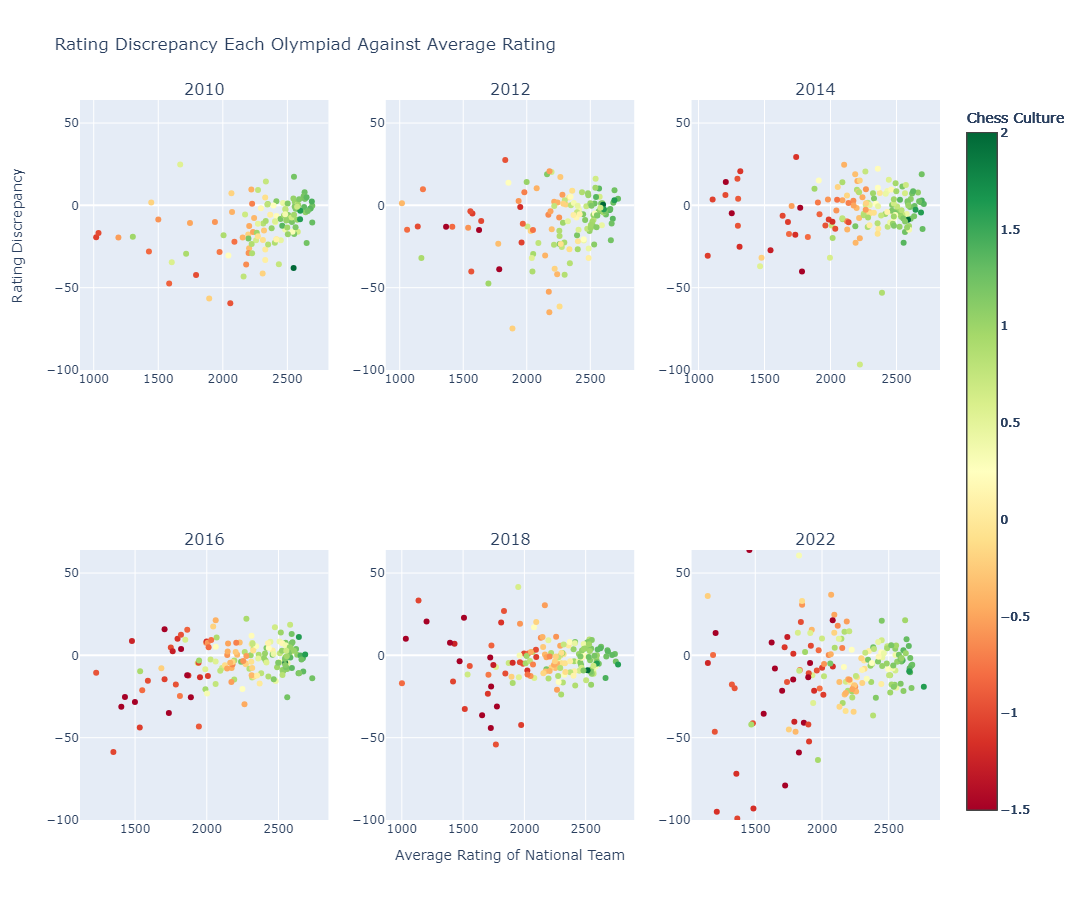

In [20]:
pivot_poar_df = per_olympiad_avg_rating.pivot(index='federation', columns='year', values=['average_ratings'])
pivot_poar_df.reset_index(inplace=True)
pivot_poar_df.columns = ['fide_code'] + [f'{year}_{col}' for year, col in pivot_poar_df.columns[1:]]
olympiad_avgrating_culture_df = pd.merge(pivot_poar_df, culture_table, on='fide_code')
olympiad_avgrating_culture_df = pd.merge(olympiad_avgrating_culture_df, country_performance_olympiads_df, on=['id','fide_code'])

x_cols=['average_ratings_{}'.format(year) for year in OLYMPIAD_YEARS] 
y_cols=[year for year in OLYMPIAD_YEARS]
olympiad_avgrating_culture_vis = make_scatter_six_olympiad(olympiad_avgrating_culture_df,x_cols,y_cols)

olympiad_avgrating_culture_vis.update_layout(title_text='Rating Discrepancy Each Olympiad Against Average Rating', showlegend=False)
olympiad_avgrating_culture_vis.update_xaxes(title_text='Average Rating of National Team', row=2, col=2)
olympiad_avgrating_culture_vis.update_yaxes(title_text='Rating Discrepancy', row=1, col=1)
olympiad_avgrating_culture_vis.show()

### 7. Correlation Matrix and Heatmap
1. **Prepare Related Dataframes:** 
We first created sub-dataframes with one 'id' column corresponding to country id, and the other columns corresponding to variables of interest to be included in the correlation matrix. Specifically:

| dataframe  |  variable captured | Method |
|:---|:---|:------|
| **master_rate_for_analyse_df**  | **master_rate(culture1)**  |  retrieve per_capita_master_log column from gm_per_capita_df above (log of master score of the country scaled by country population) |
| **master_rate_for_analyse_df**  | **master_metric(culture2)**  |  retrieve metric column from gm_per_capita_df above (master score multiply with log of master score of the country scaled by country population) |
| **chess_culture_df_for_analyse_df**  | **chess_culture(culture3)**  |  retrieve chess_culture column from culture_table above (distance to chess hub based standardized chess culture index) |
| **gdp_per_capita_for_analyse_df**  | **gdp_per_capita**  |  retrieve gdp per capita of each year from gdp_per_capita_df and take average over the years |
| **log_gdp_per_capita_for_analyse_df**  | **log_gdp_per_capita**  |  log of the average gdp per capita per year |
| **country_performance_olympiads_for_analyse_df**  | **performance_discrepancy**  |  average from country_performance_olympiads_df above |

**Then we join all the sub-dataframes through the 'id' column into the `analyse_combine_df` dataframe.**

**Handling Missing Data:** 
When calculating average gdp per capita or average log gdp per capita, there are na values for some countries. For those, we remove the na values, and for corresponding country, calculate average using only the non-na values. We understand this may cause bias for the country. However in order to keep a large enough sample size, we use this way instead of dropping entire countries with na values. 
Also when merging the sub-dataframes we did inner join, so that only countries exist in all sub-dataframes are taken into consideration.

In [21]:
# Correlation Matrix and Heat Map
# Prepare related dataframes

# Culture Factor1: masters rate is log of master score of the country scaled by country population
master_rate_for_analyse_df = gm_per_capita_df[['id', 'per_capita_master_log', 'metric']] \
    .rename(columns={"per_capita_master_log": "culture1_master_rate", "metric": "culture2_master_metric"})

# Culture Factor3: Cultural is distance to chess hub based standardized chess culture index
chess_culture_df_for_analyse_df = culture_table[["id", "chess_culture"]] \
    .rename(columns={"chess_culture": "culture3_chess_culture_index"})

# GDP Per capita by country is average gdp per capita over the years
gdp_per_capita_df["average_per_year"] = gdp_per_capita_df.iloc[:, -13:].apply(pd.to_numeric).mean(axis=1, skipna=True)
gdp_per_capita_for_analyse_df = gdp_per_capita_df[["country_code", "average_per_year"]] \
    .rename(columns={"country_code": "id", "average_per_year": "gdp_per_capita"})

# GDP Per capita log by country is log of the average gdp per capita per year
log_gdp_per_capita_df = gdp_per_capita_df.copy().iloc[:, :-1]

col_count = 0
for column in gdp_per_capita_df.columns[:-1]:
    if isinstance(column, int):
        yearly_data = np.array(log_gdp_per_capita_df[column]).astype(np.float64)
        log_gdp_per_capita_df[log_gdp_per_capita_df.columns[col_count]] = np.log10(yearly_data)
    col_count += 1

log_gdp_per_capita_df["average_per_year"] = log_gdp_per_capita_df.iloc[:, -13:].apply(pd.to_numeric).mean(axis=1, skipna=True)
log_gdp_per_capita_for_analyse_df = log_gdp_per_capita_df[["country_code", "average_per_year"]] \
    .rename(columns={"country_code": "id", "average_per_year": "log_gdp_per_capita"})

# Discrepancy by country
country_performance_olympiads_for_analyse_df = country_performance_olympiads_df[["id", "average"]] \
    .rename(columns={"average": "performance_discrepancy"})

# Join all factors by country
analyse_combine_df = country_performance_olympiads_for_analyse_df \
    .merge(gdp_per_capita_for_analyse_df, on='id') \
    .merge(log_gdp_per_capita_for_analyse_df, on='id') \
    .merge(master_rate_for_analyse_df, on='id') \
    .merge(chess_culture_df_for_analyse_df, on='id')

analyse_combine_df = analyse_combine_df.iloc[:, 1 - len(analyse_combine_df.columns):].apply(pd.to_numeric)

2. **Create Correlation Matrix and Heatmap:** using the analyse_combine_df we obtained from setp 1 above, which contains an id column and multiple columns each corresponding to a factor of interest, we generate a correlation matrix across the factors of interest. Then using that correlation matrix we generate the heatmap. 

**Two Correlation Heatmaps:**
We first created a heatmap for all the factors of interest. From that we found among the 3 culture factors, chess culture(culture 3) seem to have stronger correlation with performance_discrepancy, so we plotted another heatmap taking in only the chess culture of the 3 culture factors, performance_discrepancy, gdp_per_capita, log_gdp_per_capita. We also included an interaction term: chess culture x log_gdp_per_capita as we observed relatively strong correlation between these two factors.  

<AxesSubplot: title={'center': 'Correlation Matrix Heatmap for Performance Discrepancy, GDP per Capita, and Culture Metric'}>

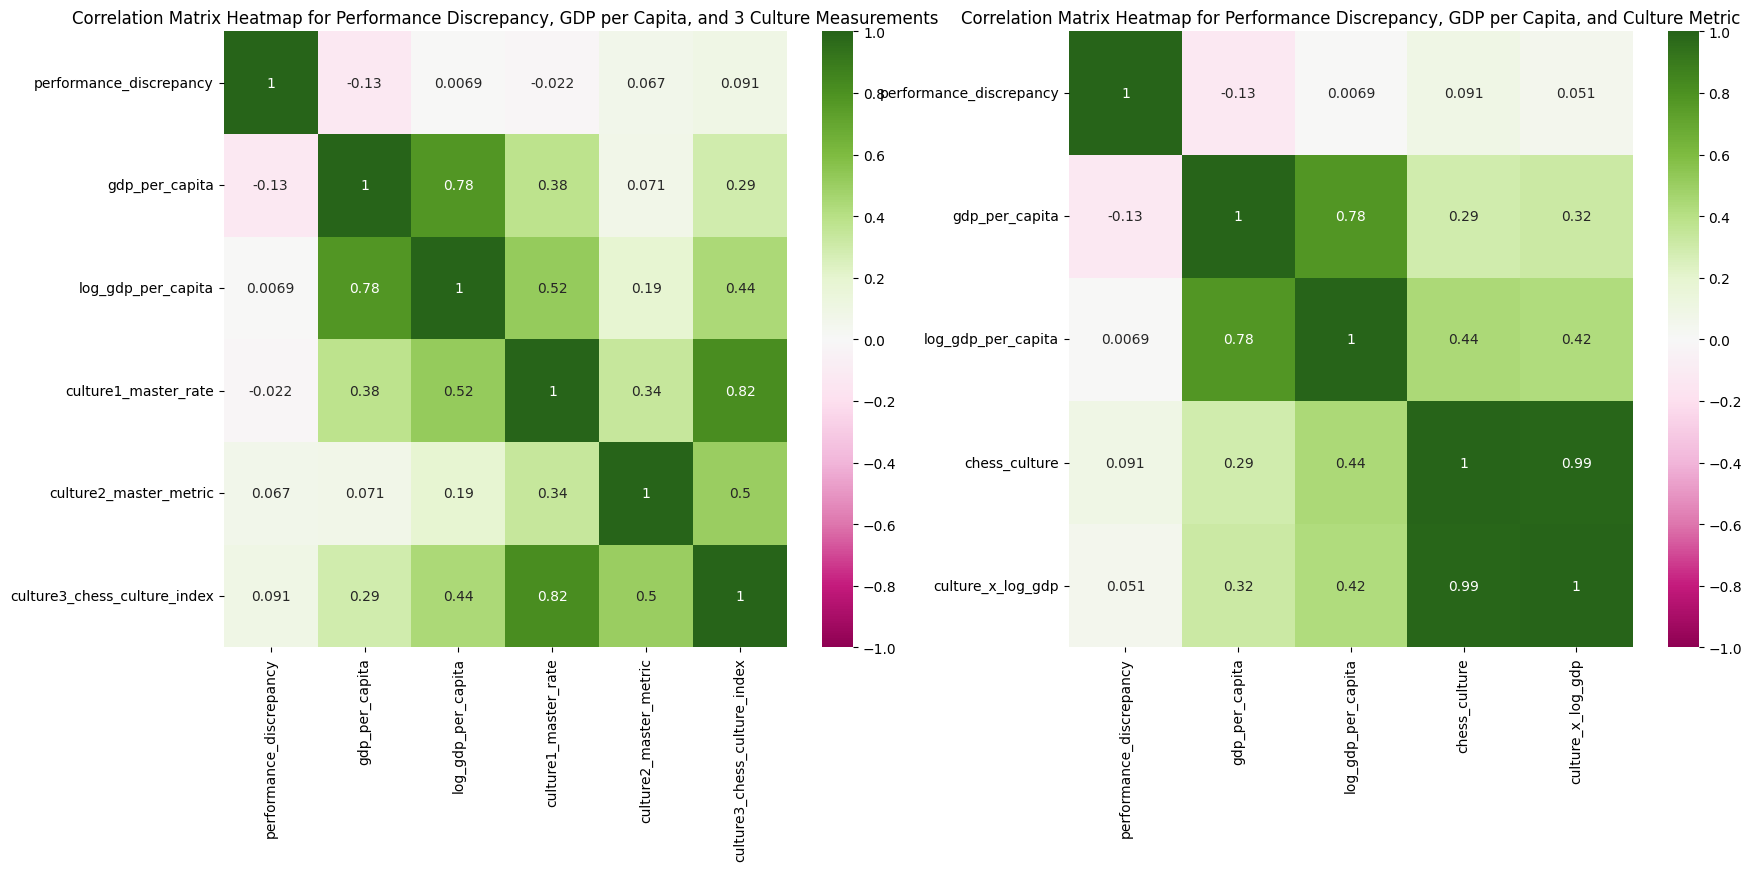

In [22]:
# Correlation Matrix and Heat Map
# Set plot size and initial layout
fig = plt.figure(figsize=(20, 8))
gs0 = matplotlib.gridspec.GridSpec(1, 2, figure=fig)
ax1 = fig.add_subplot(gs0[0, 0])
ax2 = fig.add_subplot(gs0[0, 1])
ax1.title.set_text('Correlation Matrix Heatmap for Performance Discrepancy, GDP per Capita, and 3 Culture Measurements')
ax2.title.set_text('Correlation Matrix Heatmap for Performance Discrepancy, GDP per Capita, and Culture Metric')

# Generate correlation matrix and corresponding heatmap for performance discrepancy, GDP per capita, and 3 culture factors
analyse_combine_iris_corr_matrix = analyse_combine_df.corr()
sns.heatmap(analyse_combine_iris_corr_matrix, cmap="PiYG", annot=True, 
            cbar_kws={'ticks': [-1, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0]}, 
            vmin=-1, vmax=1, ax=ax1)

# Generate correlation matrix and corresponding heatmap for performance discrepancy, GDP per capita, and Cultural Metric
chess_culture_df_for_analyse_df = chess_culture_df_for_analyse_df.rename(columns={"culture3_chess_culture_index": "chess_culture"})
analyse_combine_df = country_performance_olympiads_for_analyse_df \
    .merge(gdp_per_capita_for_analyse_df, on='id') \
    .merge(log_gdp_per_capita_for_analyse_df, on='id') \
    .merge(chess_culture_df_for_analyse_df, on='id')
analyse_combine_df = analyse_combine_df.iloc[:, 1 - len(analyse_combine_df.columns):].apply(pd.to_numeric)
analyse_combine_df['culture_x_log_gdp'] = analyse_combine_df['log_gdp_per_capita'] * analyse_combine_df['chess_culture']
analyse_combine_iris_corr_matrix = analyse_combine_df.corr()
sns.heatmap(analyse_combine_iris_corr_matrix, cmap="PiYG", annot=True, 
            cbar_kws={'ticks': [-1, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0]}, 
            vmin=-1, vmax=1, ax=ax2)

3. **Ordinary Least Square Regression Analysis:** We then do a regression with the factors with stronger correlation coefficient with performance discrepency: chess_culture and log_gdp_per_capita as well as their interaction term, and we see that chess_culture and culture_x_log_gdp have relatively significant coefficient. However beccause R-squared is quite small. We are not sure how well the model explains the observed data.

In [23]:
X = analyse_combine_df[['chess_culture', 'log_gdp_per_capita', 'culture_x_log_gdp']]
X = sm.add_constant(X)
y = analyse_combine_df['performance_discrepancy']
model = sm.OLS(y, X).fit()
print(model.summary())

                               OLS Regression Results                              
Dep. Variable:     performance_discrepancy   R-squared:                       0.072
Model:                                 OLS   Adj. R-squared:                  0.057
Method:                      Least Squares   F-statistic:                     4.603
Date:                     Sun, 01 Oct 2023   Prob (F-statistic):            0.00397
Time:                             13:04:07   Log-Likelihood:                -659.09
No. Observations:                      181   AIC:                             1326.
Df Residuals:                          177   BIC:                             1339.
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

### 8. Line Plot of Performance Discrepency of Different Country Groups over the 6 Olympiads                                                                                                
A. **Prepare Related Dataframes:** 

**1. the initial dataframe:** We first create a `gdp_perform_df` dataframe that list out for each country: average gdp per capita over the years, and the performance discrepency of the country in each of the 6 Olympiads. We then sort this dataframe by the average gdp per capita per year. 


**Handling Missing Data:** 
We remove any country whose performance discrepancy for any of the 6 Olympiads is na. That is, we only take in countries that has performance discrepancy values for all 6 Olympiads.

In [24]:
# Retrieve country performance discrepency by year
gm_per_capita_df_for_analyse_df = (gm_per_capita_df[["id", "metric"]]).rename(columns={"metric":"culture2_master_metric"})
columns = ['id'] + OLYMPIAD_YEARS
columns_str = [str(colname) for colname in columns]
years_str = [str(year) for year in OLYMPIAD_YEARS]

country_perfm_byyear_df = (country_performance_olympiads_df[columns]).dropna()
country_perfm_byyear_df.columns = columns_str
gdp_percapita_average_df = (gdp_per_capita_df[["country", "country_code", "average_per_year"]]).dropna().rename(columns={"country_code":"id", "average_per_year":"average_gdp_per_year"})
# Retrieve gdp per capita averaging over the years
gdp_percapita_average_df["average_gdp_per_year"] = (gdp_percapita_average_df["average_gdp_per_year"]).apply(pd.to_numeric)
# Join average gdp per capita values with performance discrepency to ensure country does have performance discrepency value
gdp_perform_df = gdp_percapita_average_df.merge(country_perfm_byyear_df,on='id').merge(gm_per_capita_df_for_analyse_df, on='id').sort_values('average_gdp_per_year')

**2. split_two_groups:** Function that takes in two numbers: num_top_group, num_bottom_group. based on the two numbers do the following:
- **Take out two groups** from `gdp_perform_df` one group with num_top_group number of top gdp per capita countries, the other with num_bottom_group bottom gdp per capita countries. 
- **For the two groups,** we do a melt to the corresponding dataframes so that the melted dataframe can be used to loop through each country and plot the line graph of performance discrepancy over the 6 Olympiad for the country.     
- **For the two groups,** we also calculate corresponding mean and standard deviation of performance discrepancy to be plot out over the 6 Olympiads. 

In [25]:
#function to divide up the groups
def split_two_groups(num_top_group, num_bottom_group, gdp_perform_df):
    # Find the top num_top_group average gdp_per_capita countries, and bottom num_bottom_group average gdp_per_capita countreis
    gdp_perform_rich_df = gdp_perform_df.head(num_top_group)[columns_str]
    gdp_perform_poor_df = gdp_perform_df.tail(num_bottom_group)[columns_str]
    # Prepare data for plotting discrepency by year line plots
    gdp_perform_rich_melt_df = pd.melt(
        gdp_perform_rich_df, 
        id_vars=['id'], 
        value_vars=years_str, 
        var_name='year', 
        value_name='performance_descrepency'
    )
    gdp_perform_poor_melt_df = pd.melt(
        gdp_perform_poor_df, 
        id_vars=['id'], 
        value_vars=years_str, 
        var_name='year', 
        value_name='performance_descrepency'
    )
    
    # calculate standardeviation of performence discrepency grouped by top and bottom 25 gdp per capita countries
    rich_std = gdp_perform_rich_melt_df[['year','performance_descrepency']].groupby('year').std()
    poor_std = gdp_perform_poor_melt_df[['year','performance_descrepency']].groupby('year').std()
    rich_std['year'] = rich_std.index
    poor_std['year'] = poor_std.index
    # calculate mean of performence discrepency grouped by top and bottom 25 gdp per capita countries
    rich_mean = gdp_perform_rich_melt_df[['year','performance_descrepency']].groupby('year').mean()
    poor_mean = gdp_perform_poor_melt_df[['year','performance_descrepency']].groupby('year').mean()
    rich_mean['year'] = rich_mean.index
    poor_mean['year'] = poor_mean.index
    
    rich_ids=gdp_perform_rich_df.id
    poor_ids=gdp_perform_poor_df.id
    
    return (rich_ids, poor_ids, gdp_perform_rich_melt_df, gdp_perform_poor_melt_df, rich_std, poor_std, rich_mean, poor_mean)

**3. plot_two_groups:** Function that plot out different groupings derived from split_two_groups:
- We first plot line graphs of the num_top_group countries in the  `[num_top_group countries with the highest average gdp per capita]` with orange line color, line width 1, and 0.2 line opacity; as well as line graphs of the num_bottom_group countries in the `[num_bottom_group countries with the lowest average gdp per capita]` with green line color, line width 1, and 0.2 line opacity. 
- We then plot the line graph of the mean of num_top_group countries in the `[num_top_group countries with the highest average gdp per capita]` with orange line color, line width 3; as well as the line graph of the mean of num_bottom_group countries in the `[num_bottom_group countries with the lowest average gdp per capita]` with green line color, line width 3, line style dashed. 

In [26]:
def plot_two_groups(theax, num_top_group, num_bottom_group, rich_ids, poor_ids, gdp_perform_rich_melt_df, gdp_perform_poor_melt_df, rich_std, poor_std, rich_mean, poor_mean):
    x_vals = years_str
    for cid in rich_ids:
        cur_desc_df = (gdp_perform_rich_melt_df[gdp_perform_rich_melt_df['id']==cid])
        y_vals = cur_desc_df["performance_descrepency"]
        theax.plot(x_vals, y_vals, color='#ff7400', alpha=0.2, linewidth=1)

    for cid in poor_ids:
        cur_desc_df = (gdp_perform_poor_melt_df[gdp_perform_poor_melt_df['id']==cid])
        y_vals = cur_desc_df["performance_descrepency"]
        theax.plot(x_vals, y_vals, color='#009f29', alpha=0.2, linewidth=1)

    #plot the standard deviation and mean of the two groups over years
    theax.plot(poor_mean['year'], poor_mean['performance_descrepency'], color='#009f29', linewidth=3, label='Mean of Performance Discrepancy among '+str(num_bottom_group)+' Lowest gdp_per_capita countries')
    theax.plot(rich_mean['year'], rich_mean['performance_descrepency'], color='#ff7400', linewidth=3, label='Mean of Performance Discrepancy among '+str(num_top_group)+' Highest gdp_per_capita countries')
    theax.plot(poor_std['year'], poor_std['performance_descrepency'], color='#009f29', linestyle='dashed', linewidth=3, label='Standard Deviation of Performance Discrepancy among '+str(num_bottom_group)+' Lowest gdp_per_capita countries')
    theax.plot(rich_std['year'], rich_std['performance_descrepency'], color='#ff7400', linestyle='dashed', linewidth=3, label='Standard Deviation of Performance Discrepancy among '+str(num_top_group)+' Highest gdp_per_capita countries')

    theax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=1)
    theax.title.set_text("Change of Performance Discrepancy For Top "+str(num_top_group)+" GDP_Per_Capita Countries(orange), \nand Lower "+str(num_bottom_group)+" GDP_Per_Capita Countries(green) over 6 Olympiad")

**4. plot 3 sub-plots for 3 different groupings:** We did 3 types of groupings:
- Top 25 gdp per capita countries and bottom 25 gdp per capita countries
- Top 20 gdp per capita countries and bottom 80 gdp per capita countries
- Top 80 gdp per capita countries and bottom 80 gdp per capita countries

We also considered adopting the "80 20 rule" theory where 20% of richest countries occupy 80% of wealth in the world. However that is not quantifiable in our visualization, mainly because we do not have all countries in the world participating in the Chess Olympiad. 

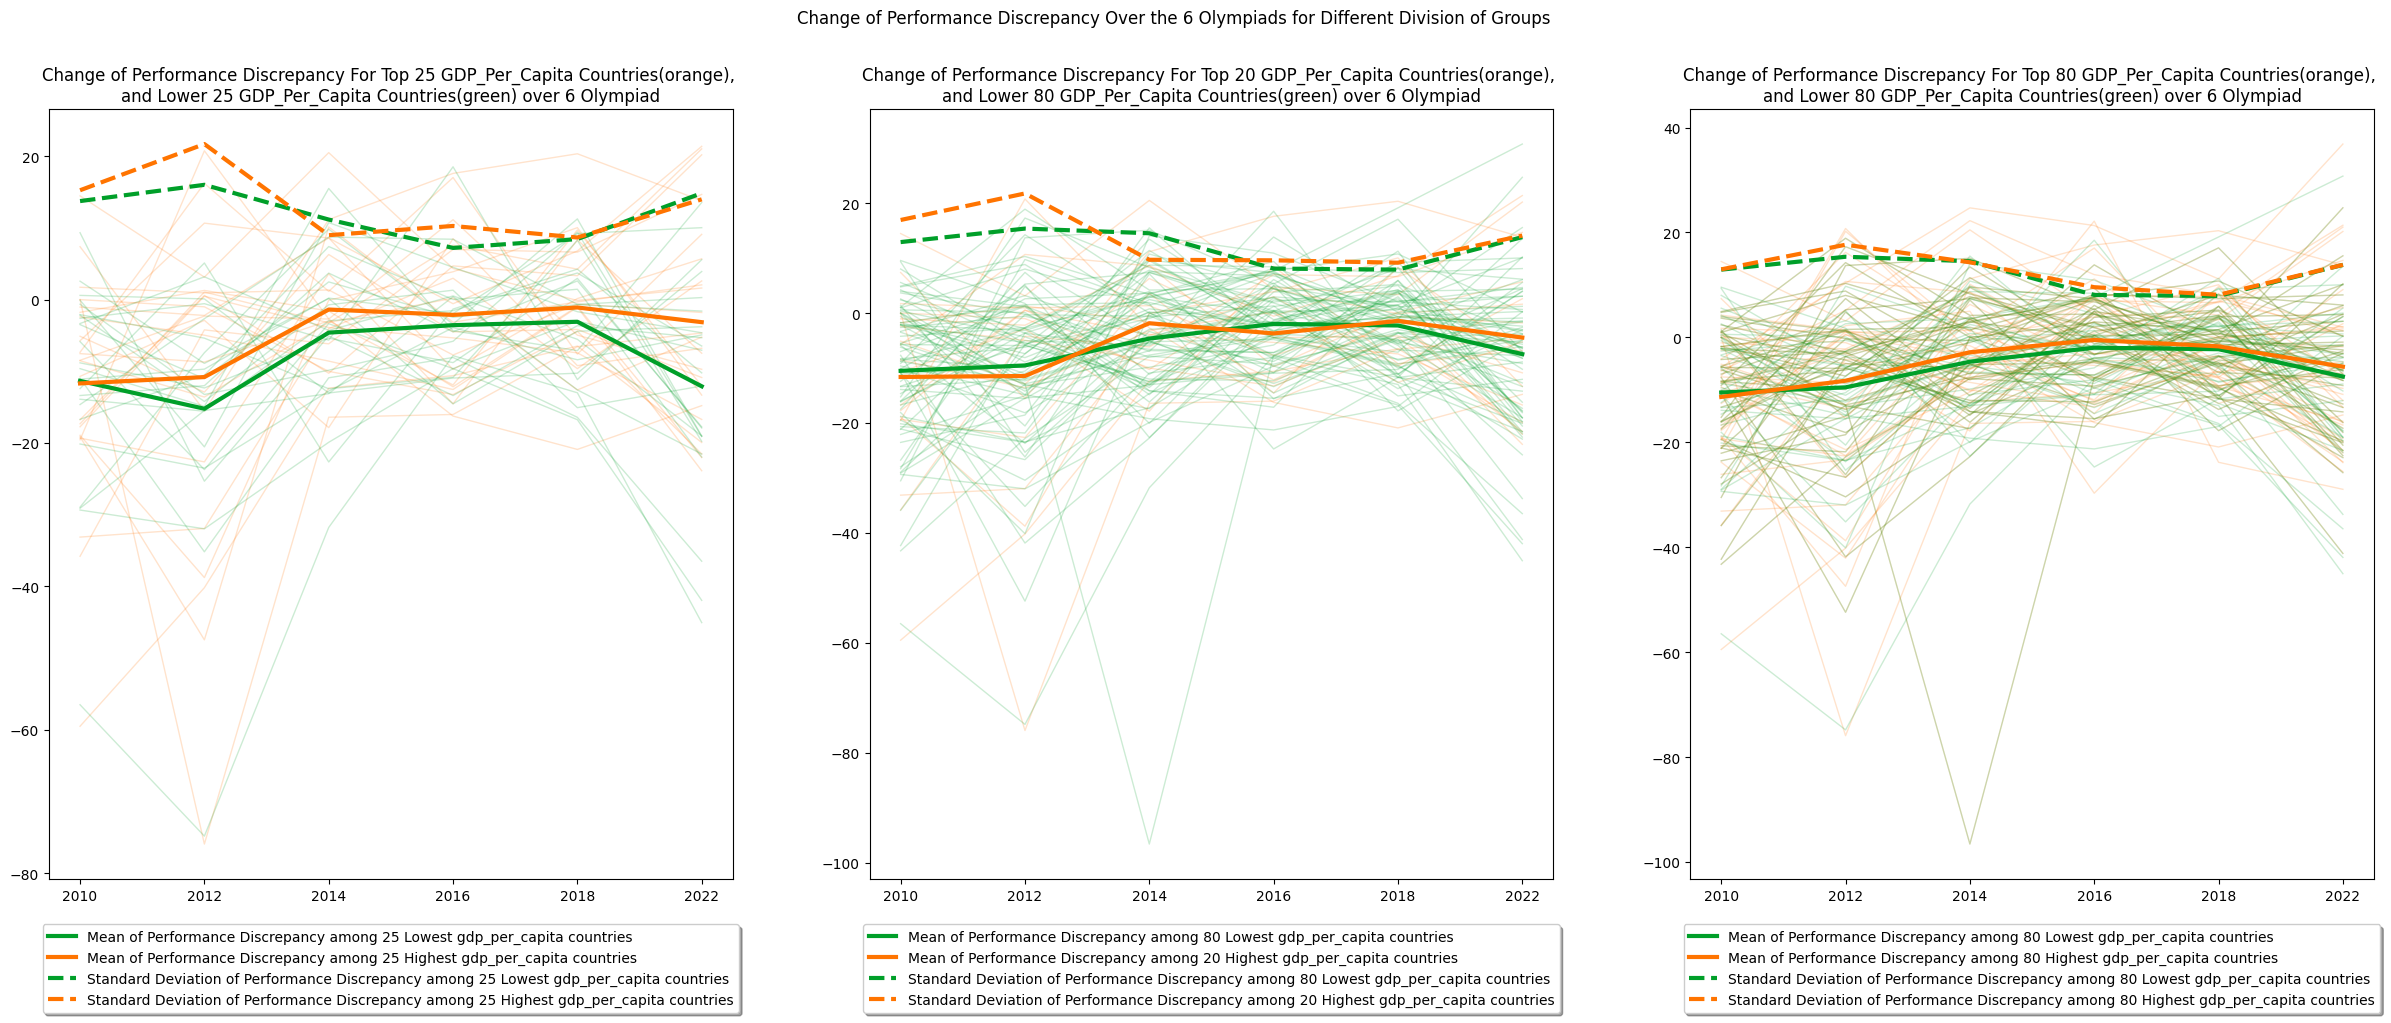

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
fig.suptitle('Change of Performance Discrepancy Over the 6 Olympiads for Different Division of Groups')
rich_ids, poor_ids, gdp_perform_rich_melt_df, gdp_perform_poor_melt_df, rich_std, poor_std, rich_mean, poor_mean = split_two_groups(25, 25, gdp_perform_df)
plot_two_groups(ax1, 25, 25, rich_ids, poor_ids, gdp_perform_rich_melt_df, gdp_perform_poor_melt_df, rich_std, poor_std, rich_mean, poor_mean)
rich_ids, poor_ids, gdp_perform_rich_melt_df, gdp_perform_poor_melt_df, rich_std, poor_std, rich_mean, poor_mean = split_two_groups(20, 80, gdp_perform_df)
plot_two_groups(ax2, 20, 80, rich_ids, poor_ids, gdp_perform_rich_melt_df, gdp_perform_poor_melt_df, rich_std, poor_std, rich_mean, poor_mean)
rich_ids, poor_ids, gdp_perform_rich_melt_df, gdp_perform_poor_melt_df, rich_std, poor_std, rich_mean, poor_mean = split_two_groups(80, 80, gdp_perform_df)
plot_two_groups(ax3, 80, 80, rich_ids, poor_ids, gdp_perform_rich_melt_df, gdp_perform_poor_melt_df, rich_std, poor_std, rich_mean, poor_mean)
plt.show()

### 9. Line Plot of Performance Discrepency of Different Country Groups over the 6 Olympiads                                                                                                
1. **plot_consistency_subplot:** 
- This is a function that takes in the following parameters:
| parameter  |  data type |  meaning |
|:---|:---|:------|
| **theax**  | sub-plot object  |  this will be used to draw the sub-plot |
| **compare_with**  | float numeric  |  the relative "mean" value, above `threshold_width` of this value will be considered overperform, below `threshold_width` of this value will be considered underperform |
| **threshold_width**  | float numeric |  a threshold width, above this value of `compare_with` will be considered overperform, below this value of `compare_with` will be considered underperform |
| **isOverPerform**  | boolean  | if true, will plot overperform plot, if false, will plot underperform plot |


- When both `compare_with` and `threshold_width` are 0, for each Olympiad game, we are getting absolute underperform or overperform status of the country, otherwise we are doing a normalized underperform or overperform status.
- For the sub-plot, we plot coutries that are either underperform at least 5 times out of 6, or overperform at least 5 times out of 6

In [28]:
def plot_consistency_subplot(theax, compare_with, threshold_width, isOverPerform):
    average_rating_discrepancy = compare_with
    ids=country_perfm_byyear_df.id
    feds = []
    
    for cid in ids:
        cur_desc_df = (country_perfm_byyear_df[country_perfm_byyear_df['id']==cid])
        current_positive = 0
        for year in years_str:
            if(isOverPerform == True):
                if cur_desc_df[year].values[0] > average_rating_discrepancy + threshold_width:
                    current_positive += 1
            else:
                if cur_desc_df[year].values[0] < average_rating_discrepancy - threshold_width:
                    current_positive -= 1
        if year == years_str[-1]:
            if(isOverPerform == True):
                if (current_positive>4):
                    cur_desc_df = cur_desc_df[years_str].T
                    cur_desc_df['year'] = cur_desc_df.index
                    cur_desc_df.columns.values[0] = "performance_discrepency"
                    if theax != None:
                        theax.plot(cur_desc_df['year'], cur_desc_df['performance_discrepency'], label=cid)
                    feds.append(cid)
            else:
                if (current_positive<-4):
                    cur_desc_df = cur_desc_df[years_str].T
                    cur_desc_df['year'] = cur_desc_df.index
                    cur_desc_df.columns.values[0] = "performance_discrepency"
                    if theax != None:
                        theax.plot(cur_desc_df['year'], cur_desc_df['performance_discrepency'], label=cid)
                    feds.append(cid)
    if theax != None:
        theax.title.set_text('Countries and Regions Underperform in Majority(5 out of 6) of the Olympiads')
        theax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=10)
        if(isOverPerform == True):
            theax.title.set_text('\nCountries and Regions Overperform in Majority(5 out of 6) of the Olympiads\nCompare with: '+str(compare_with)+', Threshold width: '+str(threshold_width))
        else:
            theax.title.set_text('\nCountries and Regions Underperform in Majority(5 out of 6) of the Olympiads\nCompare with: '+str(compare_with)+', Threshold width: '+str(threshold_width))
    return feds

**2. plot 4 sub-plots for absolute or normalized overperform underperform statuses:** 

We did 4 sub-plots:
- First Row, absolute statuses: Compare with 0, Threshold 0
    - Left: Countries overperform at least 5 times out of 6
    - Right: Countries overperform at least 5 times out of 6 
- Second Row, normalized statuses: Compare with -5, Threshold 5*0.5 (The reason why we pick -5 to be compared with is because from above analysis we found that average mean performance discrepency of all years is arround -5.77)
    - Left: Countries overperform at least 5 times out of 6
    - Right: Countries overperform at least 5 times out of 6 

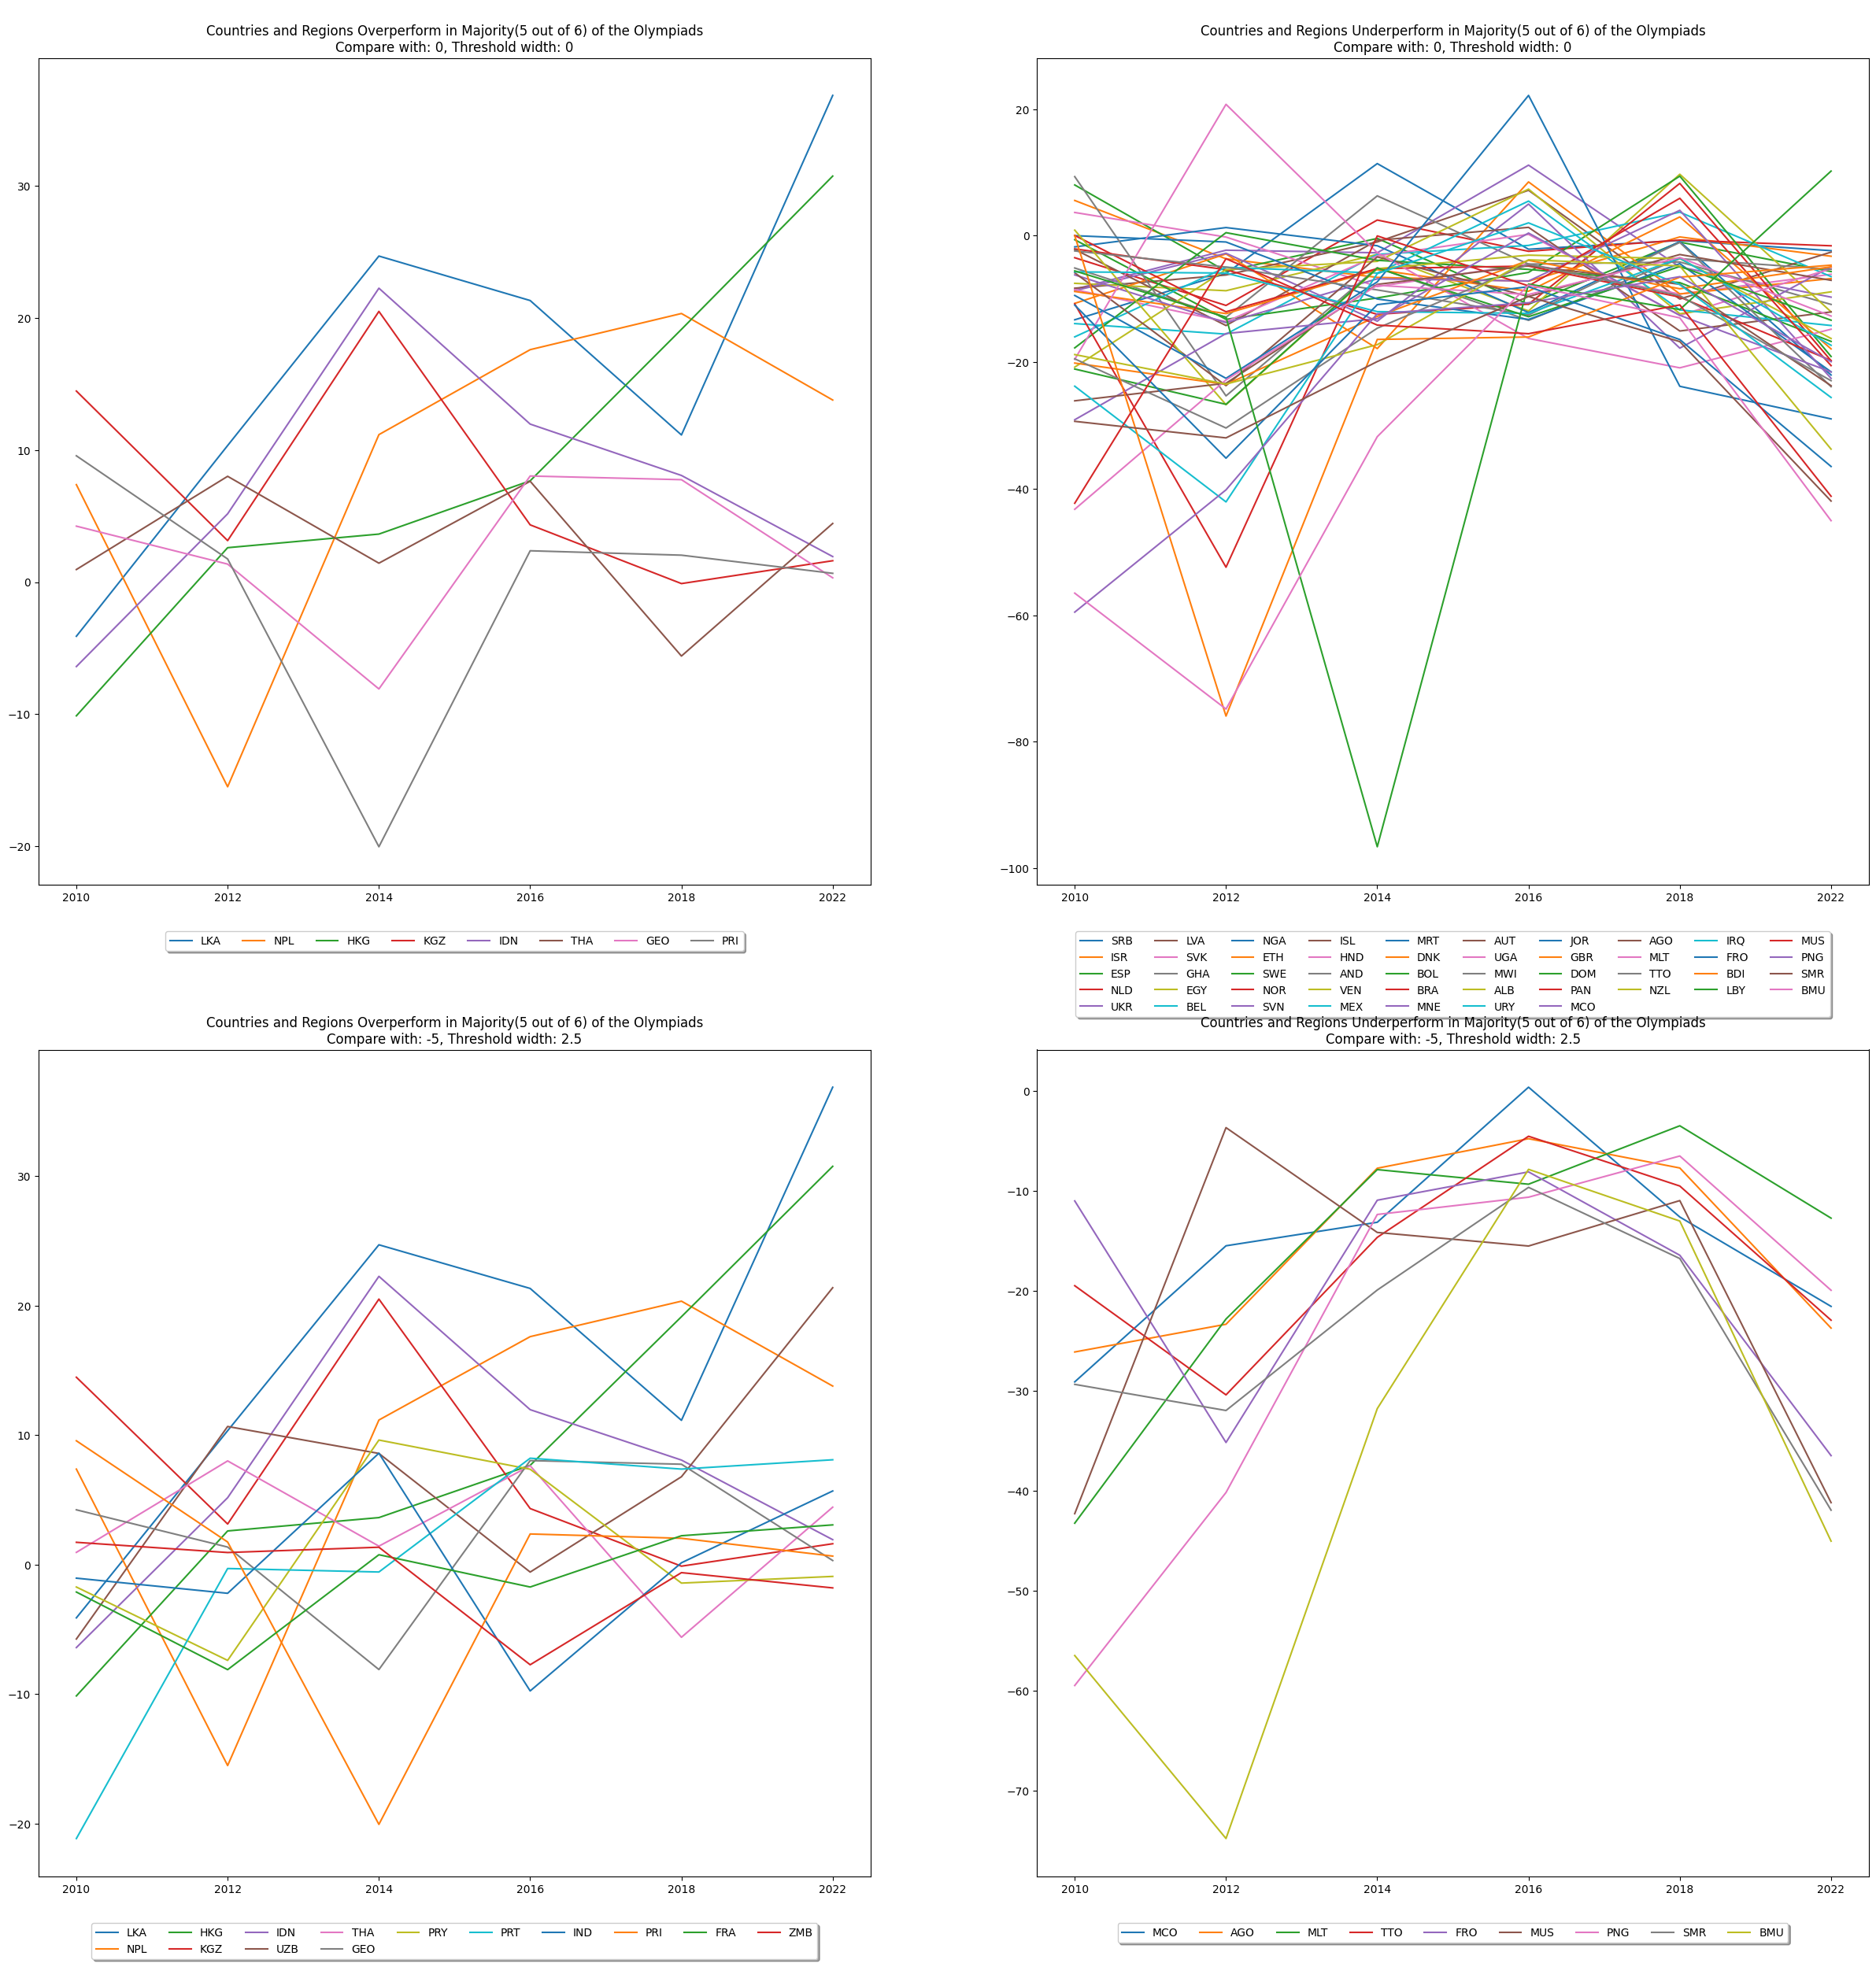

In [29]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(30, 30))
# fig.suptitle('Consistent Overperform and Underperform Countries Absolute and Normalized')
plot_consistency_subplot(ax1, 0, 0, True)
plot_consistency_subplot(ax2, 0, 0, False)
plot_consistency_subplot(ax3, -5, (5*0.5), True)
plot_consistency_subplot(ax4, -5, (5*0.5), False)
plt.show()

**3. What Federations? What Statistics?** 

For those curious to see how the overperforming countries compare to underperforming countries, the following function neatly organizes the subjects into a tabular view (and optional scatterplot).

In [30]:
def view_over_under_perfs(compare_with, threshold_width, showvis=False):
    '''
    chess culture is a good predictor of overperformance, but rich countries with chess cultures tend to underperform.
    We can see from the scatterplot, underperforming countries are rich and culture-rich or poor and culture-poor
    While overperforming countries are generally small countries.
    '''
    overperfs = plot_consistency_subplot(None, compare_with, threshold_width, True)
    underperfs = plot_consistency_subplot(None, compare_with, threshold_width, False)
    cols = ['country', 'fide_code', 'average', 'chess_culture', '2010_norm', '2012_norm', '2014_norm', '2016_norm', '2018_norm', '2022_norm']
    underperf_df = olympiad_gdp_culture_df[olympiad_gdp_culture_df['id'].isin(underperfs)][cols]
    underperf_df['gdp_avg_norm'] = underperf_df.iloc[:, -6:].mean(axis=1)
    underperf_df['perf'] = -1
    
    overperf_df = olympiad_gdp_culture_df[olympiad_gdp_culture_df['id'].isin(overperfs)][cols]
    overperf_df['gdp_avg_norm'] = overperf_df.iloc[:, -6:].mean(axis=1)
    overperf_df['perf'] = 1
    
    perf_df = pd.concat([underperf_df, overperf_df], axis=0)
    
    color_scale = px.colors.diverging.RdYlGn
    fig = px.scatter(perf_df, 
                     x='gdp_avg_norm', 
                     y='chess_culture', 
                     color='average',
                     hover_data=['fide_code', 'average', 'country'],
                     color_continuous_scale=color_scale)
    fig.update_traces(marker=dict(size=12), selector=dict(mode='markers+text'))
    fig.update_layout(title='Scatter Plot of GDP vs. Chess Culture',
                      xaxis_title='GDP Average (Normalized)',
                      yaxis_title='Chess Culture',
                      hoverlabel=dict(bgcolor="white", font_size=12))
    fig.update_layout(height=500, width=500)
    if showvis:
        fig.show()
    return perf_df

In [31]:
view_over_under_perfs(-5,2.5).sample(5, random_state=23)

country fide_code    average  chess_culture  2010_norm  2012_norm  \
143      India       IND   0.241951       1.327037   2.997169   3.130538   
101   Paraguay       PAR   0.925505       0.162031   3.639529   3.672367   
117  Indonesia       INA   7.167298       0.211366   3.331304   3.490582   
37       Malta       MLT -16.556818       0.780235   4.346456   4.338435   
0       Monaco       MNC -15.231692       0.880170   5.309837   5.208927   

     2014_norm  2016_norm  2018_norm  2022_norm  gdp_avg_norm  perf  
143   3.156555   3.193087   3.234082   3.281765      3.165532     1  
101   3.749832   3.821476   3.760348   3.728625      3.728696     1  
117   3.564454   3.541158   3.551306   3.590576      3.511563     1  
37    4.352697   4.427377   4.408644   4.465338      4.389824    -1  
0     5.218790   5.291752   5.242060   5.261352      5.255453    -1

In [32]:
%load_ext watermark
%watermark -v -m -p pandas,numpy,plotly,json,statsmodels

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.11.1
IPython version      : 8.15.0

pandas     : 1.5.3
numpy      : 1.24.1
plotly     : 5.17.0
json       : 2.0.9
statsmodels: 0.14.0

Compiler    : MSC v.1934 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 140 Stepping 1, GenuineIntel
CPU cores   : 8
Architecture: 64bit

